## Init

In [50]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [51]:
from FCN3 import *
import  eos_solvers as eos
import ensembling as ens
import torch 
import numpy as np
from standard_hyperparams import get_device
import standard_hyperparams as hp
%autoreload

## Ensembling

### Ensembling Initiation

In [52]:
 hp.NUM_DATA_POINTS

300

In [53]:
trainers = []
models = []
m_num = 0
for i in range(3):
    tch : SimpleNet = SimpleNet(
        hp.INPUT_DIMENSION, 
        linear_activation,
        1.0 #/hp.INPUT_DIMENSION
    )
    torch.save(tch, './Ensembles/teacher_network_'+str(i))

    teacher = tch.to(hp.DEVICE)
    # Generate a Dataset out of a teacher network
    raw_X = HypersphereData.sample_hypersphere(hp.NUM_DATA_POINTS, hp.INPUT_DIMENSION, normalized=True) 
    raw_X = raw_X.to(hp.DEVICE)
    raw_Y = teacher(raw_X).to(hp.DEVICE) + (torch.randn(hp.NUM_DATA_POINTS, 1)*hp.TARGET_NOISE).to(hp.DEVICE)
    # Stores the data
    torch.save(raw_X, './Ensembles/raw_X_'+str(i))


    for i in range(20):
        # Stores the weights of the SimpleNetwork teacher
        manager = DataManager(raw_X.detach().to(hp.DEVICE), raw_Y.detach().to(hp.DEVICE), split = 0.8)
        model = FCN3Network(
            input_dim = hp.INPUT_DIMENSION,
            hidden_width_1 = hp.HIDDEN_WIDTH_1,
            hidden_width_2 = hp.HIDDEN_WIDTH_2
        ).to(hp.DEVICE)
        tr = LangevinTrainer(
            model = model,
            manager = manager,
            weight_decay_config = hp.WEIGHT_DECAY_CONFIG,
            num_epochs = hp.NUM_EPOCHS
        )
        models.append(model)
        trainers.append(tr)

### Ensembling Train

In [54]:
hp.DEVICE

device(type='mps')

In [55]:
import os
for i, yuri in enumerate(trainers):
    print(f"Training Yuri {i}")
    yuri.train()

    torch.save(yuri.model, os.path.join('./Ensembles', f'network_{i}.pth'))
    # logger = Logger(num_epochs=yuri.train_config['num_epochs'], description=f"Training YURI {i}")
    # try:
    #     with logger:
    #         yuri.train(logger)
    #         torch.save(yuri.model, os.path.join('./Ensembles', f'network_{i}.pth'))
    # finally:
    #     pass # The logger's __exit__ should handle cleanup

Training Yuri 0
Epoch 1, Loss: 1.1335264444351196
Epoch 11, Loss: 1.1522183418273926
Epoch 21, Loss: 1.3174079656600952
Epoch 31, Loss: 1.0778882503509521
Epoch 41, Loss: 1.0803747177124023
Epoch 51, Loss: 0.8118495941162109
Epoch 61, Loss: 0.8715963363647461
Epoch 71, Loss: 1.0635513067245483
Epoch 81, Loss: 0.8936082124710083
Epoch 91, Loss: 0.9324884414672852
Epoch 101, Loss: 0.4838539958000183
Epoch 111, Loss: 0.2715039849281311
Epoch 121, Loss: 0.5246151685714722
Epoch 131, Loss: 0.4080265164375305
Epoch 141, Loss: 0.403281569480896
Epoch 151, Loss: 0.24765914678573608
Epoch 161, Loss: 0.12819769978523254
Epoch 171, Loss: 0.1360003799200058
Epoch 181, Loss: 0.1043698787689209
Epoch 191, Loss: 0.04878562316298485
Epoch 201, Loss: 0.022128025069832802
Epoch 211, Loss: 0.05272867903113365
Epoch 221, Loss: 0.029532581567764282
Epoch 231, Loss: 0.021971244364976883
Epoch 241, Loss: 0.01607068069279194
Epoch 251, Loss: 0.005746901500970125
Epoch 261, Loss: 0.009098478592932224
Epoch 271

Now that we have trained our ensemble of networks, we can go ahead and start to compute things. So the first thing I'd want to compute is the kernels of each layer. 

In [5]:
def ensemble_forward_internals(models : list, data : TensorDataset):

    inner_outputs = {}
    inner_outputs['readout'] = []
    for m in models:
        tracker = LayerOutputTracker(m)
        output = tracker.forward(data)
        inner_output = tracker.get_layer_outputs()
        for k, v in inner_output.items():
            if k not in inner_outputs:
                inner_outputs[k] = []
            inner_outputs[k].append(v)
        inner_outputs['readout'].append(output)
    return inner_outputs

test_set = manager.X[manager.train_dataset.indices]
P = test_set.shape[0]
h0_internals = torch.zeros(13,P , hp.HIDDEN_WIDTH_1)
h1_internals = torch.zeros(13, P, hp.HIDDEN_WIDTH_2)
f_internals = torch.zeros(13, P,1)
layer_outputs = ensemble_forward_internals(models, test_set)

RuntimeError: Tensor for argument weight is on cpu but expected on mps

In [91]:
layer_outputs['readout'][0].shape

torch.Size([400, 1])

In [92]:
for i in range(13):
    h0_internals[i,:,:] = layer_outputs['fc1'][i]
for i in range(13):
    h1_internals[i,:,:] = layer_outputs['fc2'][i]
for i in range(13):
    f_internals[i,:] = layer_outputs['readout'][i]

## Useless Random Sampling of a One Layer Network

This is not relevant to me because I'm just sampling the kernel of a one layer random network whose output distribution is _not_ the same thing as the output distribution of the three layered network I am interested in. 

In [ ]:
N_tchs = 20
tchs = [SimpleNet(hp.INPUT_DIMENSION, linear_activation, 1.0/hp.INPUT_DIMENSION).to(hp.DEVICE) for t in range(10)]

# Generate a Dataset out of a teacher network
raw_X_multi = HypersphereData.sample_hypersphere(hp.NUM_DATA_POINTS, hp.INPUT_DIMENSION, normalized=True) 
raw_X_multi = raw_X_multi.to(hp.DEVICE)
raw_Ys = [tch(raw_X_multi).detach() for tch in tchs]
datasets = []

for ry in raw_Ys: 

    hypersphere_dataset_: DataManager = DataManager(raw_X_multi, ry, split = 0.8)

    train_data_subset_: TensorDataset = hypersphere_dataset_.train_dataset
    train_X_ : torch.Tensor = hypersphere_dataset_.tensors[0][train_data_subset_.indices]
    train_Y_ : torch.Tensor = hypersphere_dataset_.tensors[1][train_data_subset_.indices]
    test_data_subset_: TensorDataset = hypersphere_dataset_.test_dataset
    test_X_ : torch.Tensor = hypersphere_dataset_.tensors[0][test_data_subset_.indices]
    test_Y_ : torch.Tensor = hypersphere_dataset_.tensors[1][test_data_subset_.indices]
    datasets.append({
        'train_subset': train_data_subset_,
        'test_subset': test_data_subset_,
        'train': (train_X_, train_Y_),
        'test':(test_X_, test_Y_),
        'dataset': hypersphere_dataset_

    })

teacher : SimpleNet = SimpleNet(
        hp.INPUT_DIMENSION, 
        linear_activation,
        1.0/hp.INPUT_DIMENSION
)
teacher = teacher.to(hp.DEVICE)

# Generate a single Dataset out of a teacher network
raw_X = HypersphereData.sample_hypersphere(hp.NUM_DATA_POINTS, hp.INPUT_DIMENSION, normalized=True) 
raw_X = raw_X.to(hp.DEVICE)

raw_Y = teacher(raw_X).detach().to(hp.DEVICE) + torch.randn(hp.NUM_DATA_POINTS, 1).to(hp.DEVICE)*hp.TARGET_NOISE

hypersphere_dataset: DataManager = DataManager(raw_X, raw_Y, split = 0.8)

train_data_subset: TensorDataset = hypersphere_dataset.train_dataset
train_X : torch.Tensor = hypersphere_dataset.tensors[0][train_data_subset.indices]
train_Y : torch.Tensor = hypersphere_dataset.tensors[1][train_data_subset.indices]
test_data_subset: TensorDataset = hypersphere_dataset.test_dataset
test_X : torch.Tensor = hypersphere_dataset.tensors[0][test_data_subset.indices]
test_Y : torch.Tensor = hypersphere_dataset.tensors[1][test_data_subset.indices]

In [93]:
f_internals.shape

torch.Size([13, 400, 1])

I want now to compute the kernels for each of the layers. How do I do this? I will take an einsum

$K_ijk = \text{Internals}_ijk\text{Internals}_ijk$

In [ ]:
z = 13.0**-1
H_mu_nu_w = z*(torch.einsum('imu,inu->mnu', h0_internals, h0_internals))
K_mu_nu_w = z*(torch.einsum('imu,inu->mnu', h1_internals, h1_internals))
F_mu_nu = z*(torch.einsum('imu, inu->mn', f_internals, f_internals))

f_mean = torch.mean(f_internals, dim=0)
F_mean = torch.einsum('mi,ni->mn', f_mean, f_mean)
F_mean.shape

F = F_mu_nu 

In [ ]:
L_F, V_F = torch.linalg.eig(F[:,:])
L_H, V_H = torch.linalg.eig(H_mu_nu_w[:,:,0])
L_K, V_K = torch.linalg.eig(K_mu_nu_w[:,:,0])


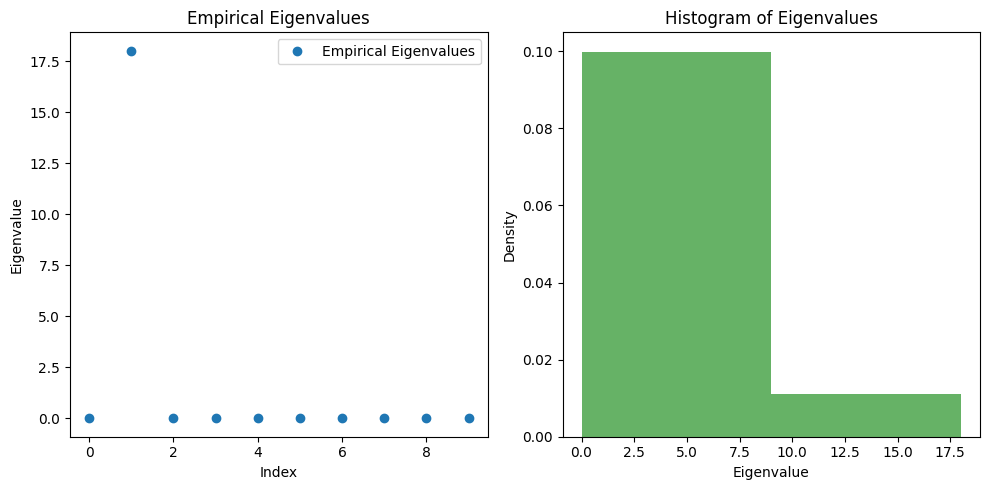

In [150]:
import matplotlib.pyplot as plt
empirical_eigenvalues = L_F.detach().numpy()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))  # 1 row, 2 columns
ax1.plot(empirical_eigenvalues, 'o', label='Empirical Eigenvalues')
ax1.set_title('Empirical Eigenvalues')
ax1.set_xlabel('Index')
ax1.set_ylabel('Eigenvalue')
ax1.legend()
ax2.hist(empirical_eigenvalues, bins=2, density=True, alpha=0.6, color='g')
ax2.set_title('Histogram of Eigenvalues')
ax2.set_xlabel('Eigenvalue')
ax2.set_ylabel('Density')
plt.tight_layout()
plt.show()


/opt/homebrew/lib/python3.10/site-packages/matplotlib/cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/opt/homebrew/lib/python3.10/site-packages/matplotlib/cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


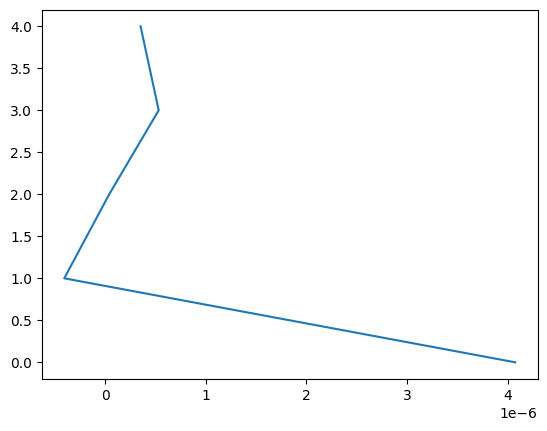

In [135]:
plt.plot(L_F.detach().numpy(), range(5))

In [ ]:
kts = np.array([np.outer(d['train'][1].detach().numpy(),d['train'][1].detach().numpy()) for d in datasets]) 

In [203]:
K_empirical = torch.mean(torch.from_numpy(kts), dim=0)  - torch.from_numpy(outer_mean)


At this point we've sampled 20 networks, computed the correlations of their outputs, and averaged. This ought to give us convergence. Let's see. 

In [204]:
K_eig_  = torch.linalg.eig(K_empirical)

In [192]:
import torch, os
def load_or_generate_tensor_tuple(f="empirical_kernel_averaged.pth", bypass_cache=False):
    if os.path.exists(f) and not bypass_cache:
        try:
            K_eig=torch.load(f, weights_only=False);
            if not isinstance(K_eig,tuple)or not all(isinstance(i,torch.Tensor)for i in K_eig):raise TypeError
            print("LOADED!!!")
            return K_eig
        except TypeError as e:
            print(e)
            pass
    
    print("LoDING Fiyled")
    return _generate_and_save_data(f)

def _generate_and_save_data(f):
    K_eig = torch.linalg.eig(K_empirical)
    try:
        torch.save(K_eig,f)
    except:
        pass
    return K_eig

In [121]:
import os
def load_ensemble_models(
    ensemble_dir='./Ensembles',
    prefix='network_',
    suffix=''
):
    return [
        torch.load(os.path.join(ensemble_dir, f), weights_only = False)
        for f in os.listdir(ensemble_dir)
        if f.startswith(prefix)
        and f.endswith(suffix)
    ]

loaded_models = load_ensemble_models()

In [122]:
loaded_models[0]

FCN3Network(
  (fc1): Linear(in_features=10, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=16, bias=True)
  (fc3): Linear(in_features=16, out_features=1, bias=True)
)

In [205]:
KERNEL_FPATH = './empirical_kernel_averaged.pth'

K_eig = K_eig_#load_or_generate_tensor_tuple(f=KERNEL_FPATH)
K_eigvals = K_eig[0].detach().numpy()
K_eigvec = K_eig[1].detach().numpy()

As a sanity check I want to see the _empirical_ eigenvalues of the data output. We see there is a single outlier and the rest of the eigenvalues are negligible, even small. The kernel is low rank because it aligns with _one_ feature direction only. 

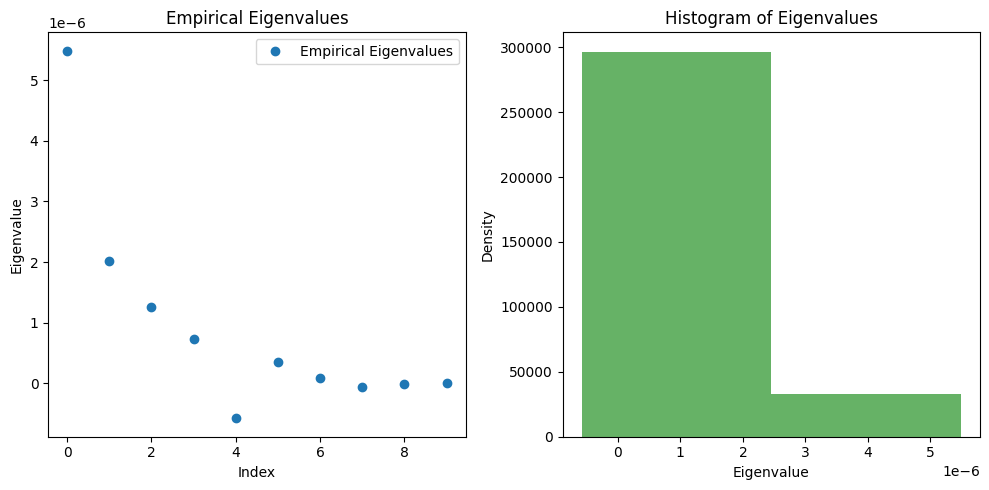

In [138]:
import matplotlib.pyplot as plt
empirical_eigenvalues = L_F.detach().numpy()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))  # 1 row, 2 columns
ax1.plot(empirical_eigenvalues, 'o', label='Empirical Eigenvalues')
ax1.set_title('Empirical Eigenvalues')
ax1.set_xlabel('Index')
ax1.set_ylabel('Eigenvalue')
ax1.legend()
ax2.hist(empirical_eigenvalues, bins=2, density=True, alpha=0.6, color='g')
ax2.set_title('Histogram of Eigenvalues')
ax2.set_xlabel('Eigenvalue')
ax2.set_ylabel('Density')
plt.tight_layout()
plt.show()


In [59]:
tracker = LayerOutputTracker(ld_model)

In [60]:
output = tracker.forward(raw_X)

In [62]:
# Here I am testing that the layer output tracker successfully
# obtains the outputs for each layer
tracker.get_layer_outputs()

{'fc1': tensor([[-0.0441,  0.1757, -0.1139,  ..., -0.4379, -0.2163,  0.0358],
         [-0.0285,  0.1010,  0.0160,  ...,  0.0306,  0.1042, -0.0942],
         [ 0.3156,  0.1262,  0.2180,  ...,  0.2063,  0.2907, -0.0922],
         ...,
         [-0.2483,  0.1269, -0.0475,  ..., -0.1074, -0.0545, -0.0058],
         [ 0.0074,  0.0327, -0.0182,  ...,  0.0778,  0.1853,  0.0075],
         [-0.1696, -0.0306, -0.0394,  ..., -0.3084, -0.0014,  0.0188]]),
 'fc2': tensor([[ 0.3027, -0.1353, -0.3418,  ..., -0.1688, -0.3864, -0.0771],
         [ 0.0282, -0.0389, -0.0332,  ..., -0.0231, -0.0426, -0.0488],
         [-0.0875,  0.0531,  0.1301,  ...,  0.0913,  0.1747,  0.0166],
         ...,
         [ 0.1114, -0.0889, -0.1271,  ..., -0.0808, -0.1663, -0.0402],
         [-0.0834,  0.0236,  0.0886,  ...,  0.0501,  0.0960,  0.0004],
         [ 0.1964, -0.0712, -0.2153,  ..., -0.0894, -0.2280, -0.0470]]),
 'fc3': tensor([[-2.1845],
         [-0.2509],
         [ 0.8186],
         [ 0.3806],
         [-1.51

In [56]:
# Using ens.eigenvalue_solver to solve the analytical eigenvalues
d: int = 10


hidden_width1: int = 32
hidden_width2: int = 16

λ1 = hp.TEMPERATURE * hp.INPUT_DIMENSION #weight decay factor
λ2 = hp.TEMPERATURE * hp.HIDDEN_WIDTH_1
λ3 = hp.TEMPERATURE * hp.HIDDEN_WIDTH_2
kappa = hp.KAPPA
k = kappa
weight_sigma1: float = 100.0
weight_sigma2: float = 1.0
weight_sigma3: float = 1.0

P: int = hp.NUM_DATA_POINTS
sigma2 = 1.0
N0 = hp.HIDDEN_WIDTH_1
N1 = hp.HIDDEN_WIDTH_2
chi =1.0

solver_params = [P, kappa, d, sigma2, N0, N1, chi]
solution = eos.eigenvalue_solver(solver_params)
lKT, lKhT, lHT, lHhT, lJT, lKp, lKhp, lHp, lHhp, lJp = solution



-----<<((Eigenvalue Solver))>>-----
Solution found:
lKT = 0.0100002940
lKhT = -9.9999699974
lHT = 0.1000000000
lHhT = -0.0100002700
lJT = 0.1000002500
lKp = 0.0000003000
lKhp = -9.9999699981
lHp = 0.1000000000
lHhp = -0.0000002901
lJp = 0.1000000000


In [102]:
empirical_eigenvalues[0]

np.float32(0.8914695)

In [104]:
lKT

np.float64(0.009999376400773198)

In [103]:
lKT - (P*chi/k)**2 * ((lHT)/(lHT + P/k))**2

np.float64(1.399796729917302e-09)

In [67]:
(P*chi/k)**2 * ((lHT)/(lHT + P/k))**2

np.float64(0.009999375000976468)

In [76]:
-chi/lHT + chi**2 * (lKT/lHT**2)

np.float64(-9.00031236297241)

In [75]:
- chi**4 * (P/k)**2 * (lHT + P/k)**-2

np.float64(-0.9999999972000874)

In [78]:
-(chi/lHT - chi**2 * (lKT/lHT**2) + chi**4 * (P/k)**2 * (lHT + P/k)**-2)

np.float64(-10.000312360172497)

In [77]:
-chi / lHp + chi**2 * lKp/lHp**2

np.float64(-9.99999986011072)

In [80]:
print(f"Target Kernel lKhT: {lKhT: .4f}")
print(f"Perp Kernel: {lKhp: .4f}")

print(f"Target H: {lHT: .7f}")
print(f"Perp H: {lHp: .7f}")

Target Kernel lKhT: -10.0003
Perp Kernel: -10.0000
Target H lKhT:  0.0999969
Perp H:  0.1000000


In [81]:
print(f"Target Hh: {lHhT: .4f}")
print(f"Perp Hh: {lHhp: .4f}")

Target Hh: -0.0100
Perp Hh: -0.0000


In [82]:
print(f"Target JT: {lJT: .4f}")
print(f"Perp Jp: {lJp: .4f}")

Target JT:  0.1000
Perp Jp:  0.1000
